In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [5]:
model = ResNet9(3, 10)
model = model.to(device)
model.load_state_dict(torch.load("drive/MyDrive/cifar10-resnet9.pth"))
model.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [6]:
#Data Set is stored externally from this folder as to not overencumber GitHub Repository
from torchvision.datasets.utils import download_url
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '../CiFar10-Data Set')

In [7]:
import os, tarfile
try:
    if (len(os.listdir('../CiFar10-Data Set/cifar10')) == 2):
        pass
except:
    with tarfile.open('../CiFar10-Data Set/cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='../CiFar10-Data Set')

In [8]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
data_dir = '../CiFar10-Data Set/cifar10'

In [9]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
tfms = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean, std)]
)
test_data_set = ImageFolder(data_dir+'/test', transform=tfms)

In [10]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_data_set.classes[preds[0].item()]

img, label = test_data_set[0]
predict_image(img, model)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


'airplane'

In [11]:
dl = torch.utils.data.DataLoader(test_data_set, batch_size=1, shuffle=False)
dl

In [12]:
for image, label in dl:
    print(image.size())
    break

torch.Size([1, 3, 32, 32])


In [13]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        print(model(images.to(device)))
        images = denormalize(images, mean, std)
        print(images.shape)
        ax.imshow(images.squeeze(0).permute(1,2,0).clamp(0,1))
        break

tensor([[23.6674, 14.3957, 16.9693, 15.6285, 12.2386, 11.8358, 12.3943, 11.9871,
         18.7864, 15.7737]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.Size([1, 3, 32, 32])


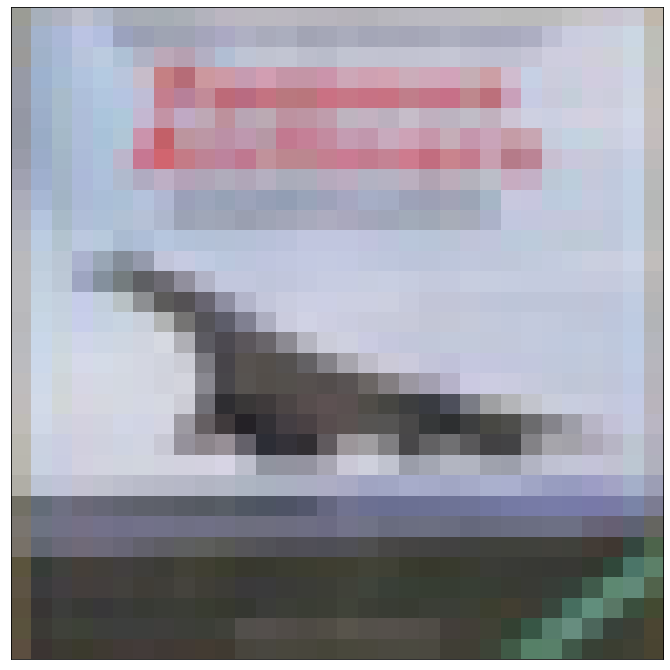

In [15]:
show_batch(dl)

In [16]:
def test(model, device, dl, epsilon):
    misclass = np.zeros(10)
    adversarial_images = []
    correct = 0
    init_correct = 0
    
    for img, label in dl:
        img, label = img.to(device), label.to(device)
        img.requires_grad = True
        output = model(img)
        if output.max(1, keepdim=True)[1] == label:
            init_correct += 1

        loss = F.cross_entropy(output, label)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data.sign()

        perturbed_image = img + epsilon*data_grad

        output = model(perturbed_image)

        final_pred = output.max(1, keepdim=True)[1]

        if final_pred == label:
            correct += 1
        else:
            adversarial_images.append((perturbed_image.cpu(), label.cpu()))
            misclass[final_pred.item()] += 1
        
    return init_correct/len(dl), correct/len(dl), adversarial_images, misclass

In [23]:
epsilon = .13
init_accuracy, accuracy, adv_imgs, misclass = test(model, device, dl, epsilon)
print(misclass)
print(os.listdir(data_dir + "/train"))
print(init_accuracy)
print(accuracy)
print(len(adv_imgs))
print(adv_imgs[0][0].size())

[ 460.  499. 1494. 1883.  963.  952.  840.  243.  512.  813.]
['ship', 'airplane', 'bird', 'deer', 'cat', 'automobile', 'truck', 'dog', 'frog', 'horse']
0.9226
0.1341
8659
torch.Size([1, 3, 32, 32])


tensor([[14.5525, 16.0225, 15.1385, 15.5155, 13.4162, 12.0958, 17.2924, 11.2483,
         25.3872, 15.2819]], device='cuda:0')
torch.Size([1, 3, 32, 32])


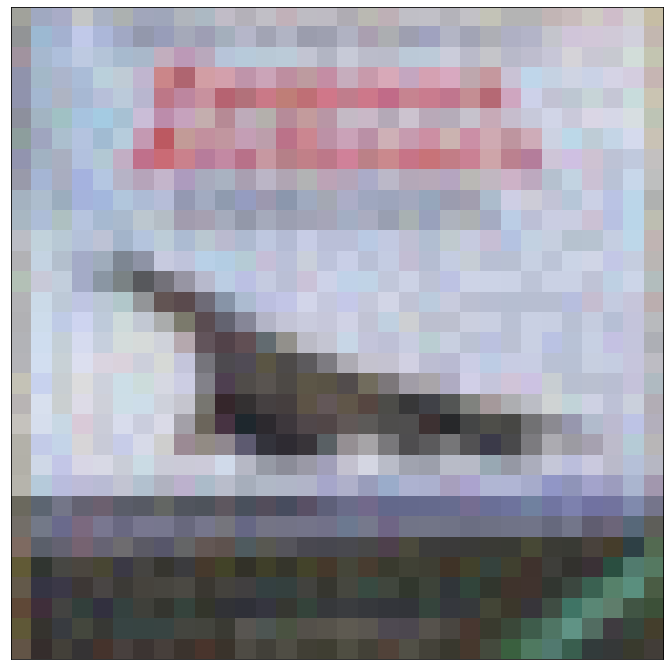

In [24]:
with torch.no_grad():
  for images, labels in adv_imgs:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([])
    ax.set_yticks([])
    print(model(images.to(device)))
    images = denormalize(images, mean, std)
    print(images.shape)
    images.detach().numpy()
    ax.imshow(images.squeeze(0).permute(1,2,0).clamp(0,1))
    break

In [25]:
data_set = test_data_set = ImageFolder(data_dir+'/train', transform=tfms)
print(data_set.classes)
print(os.listdir(data_dir + "/train"))
dl = torch.utils.data.DataLoader(data_set, batch_size=1, shuffle=False)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['ship', 'airplane', 'bird', 'deer', 'cat', 'automobile', 'truck', 'dog', 'frog', 'horse']


In [26]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return F.relu(x)
model.classifier[3] = Identity()
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [27]:
outputs = np.empty((len(dl) + len(adv_imgs), 512)) #+ len(adv_imgs)
labels = []
x=0
for img, label in dl:
    img = img.to(device)
    output = model(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(test_data_set.classes[int(label.item())])
    x += 1

for img, label in adv_imgs:
    img = img.to(device)
    output = model(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(test_data_set.classes[int(label.item())])
    x += 1

print(outputs.shape)
print(len(labels))
print(x)

(58659, 512)
58659
58659


In [28]:
outputs

array([[0.        , 1.22844374, 0.29369661, ..., 1.15117407, 0.99593782,
        1.09871793],
       [0.10439223, 0.56185746, 0.74313295, ..., 0.55841351, 0.58430135,
        1.10972083],
       [0.37754333, 1.4464792 , 0.54533166, ..., 2.20371103, 0.55439246,
        2.41290808],
       ...,
       [0.22010323, 0.        , 0.25744104, ..., 0.96626431, 0.31083724,
        0.61980808],
       [0.22519597, 0.26633999, 0.68760067, ..., 0.88635463, 0.37338656,
        0.54745257],
       [0.45129862, 1.04215145, 0.87380427, ..., 0.17826539, 0.65835238,
        0.66889119]])

In [29]:
print(labels[:5])

['airplane', 'airplane', 'airplane', 'airplane', 'airplane']


In [30]:
import time
import seaborn as sns
from sklearn import manifold
from sklearn.manifold import TSNE
import pandas as pd

In [31]:
time_start = time.time()
tsne2d = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne2d_results = tsne2d.fit_transform(outputs)
print('t-SNE done in {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 58659 samples in 6.073s...
[t-SNE] Computed neighbors for 58659 samples in 2161.613s...
[t-SNE] Computed conditional probabilities for sample 1000 / 58659
[t-SNE] Computed conditional probabilities for sample 2000 / 58659
[t-SNE] Computed conditional probabilities for sample 3000 / 58659
[t-SNE] Computed conditional probabilities for sample 4000 / 58659
[t-SNE] Computed conditional probabilities for sample 5000 / 58659
[t-SNE] Computed conditional probabilities for sample 6000 / 58659
[t-SNE] Computed conditional probabilities for sample 7000 / 58659
[t-SNE] Computed conditional probabilities for sample 8000 / 58659
[t-SNE] Computed conditional probabilities for sample 9000 / 58659
[t-SNE] Computed conditional probabilities for sample 10000 / 58659
[t-SNE] Computed conditional probabilities for sample 11000 / 58659
[t-SNE] Computed conditional probabilities for sample 12000 / 58659
[t-SNE] Computed conditional probabilities for

In [32]:
tsne2_subset = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])

tsne2_subset['tsne-2d-one'] = tsne2d_results[:,0]
tsne2_subset['tsne-2d-two'] = tsne2d_results[:,1]

print(tsne2_subset.head())

   tsne-2d-one  tsne-2d-two
0    -1.537353     1.142836
1    -2.035025     2.778986
2    -1.435931     1.603877
3    -1.866394     1.853926
4    -1.358124     0.720810


<Figure size 720x720 with 0 Axes>

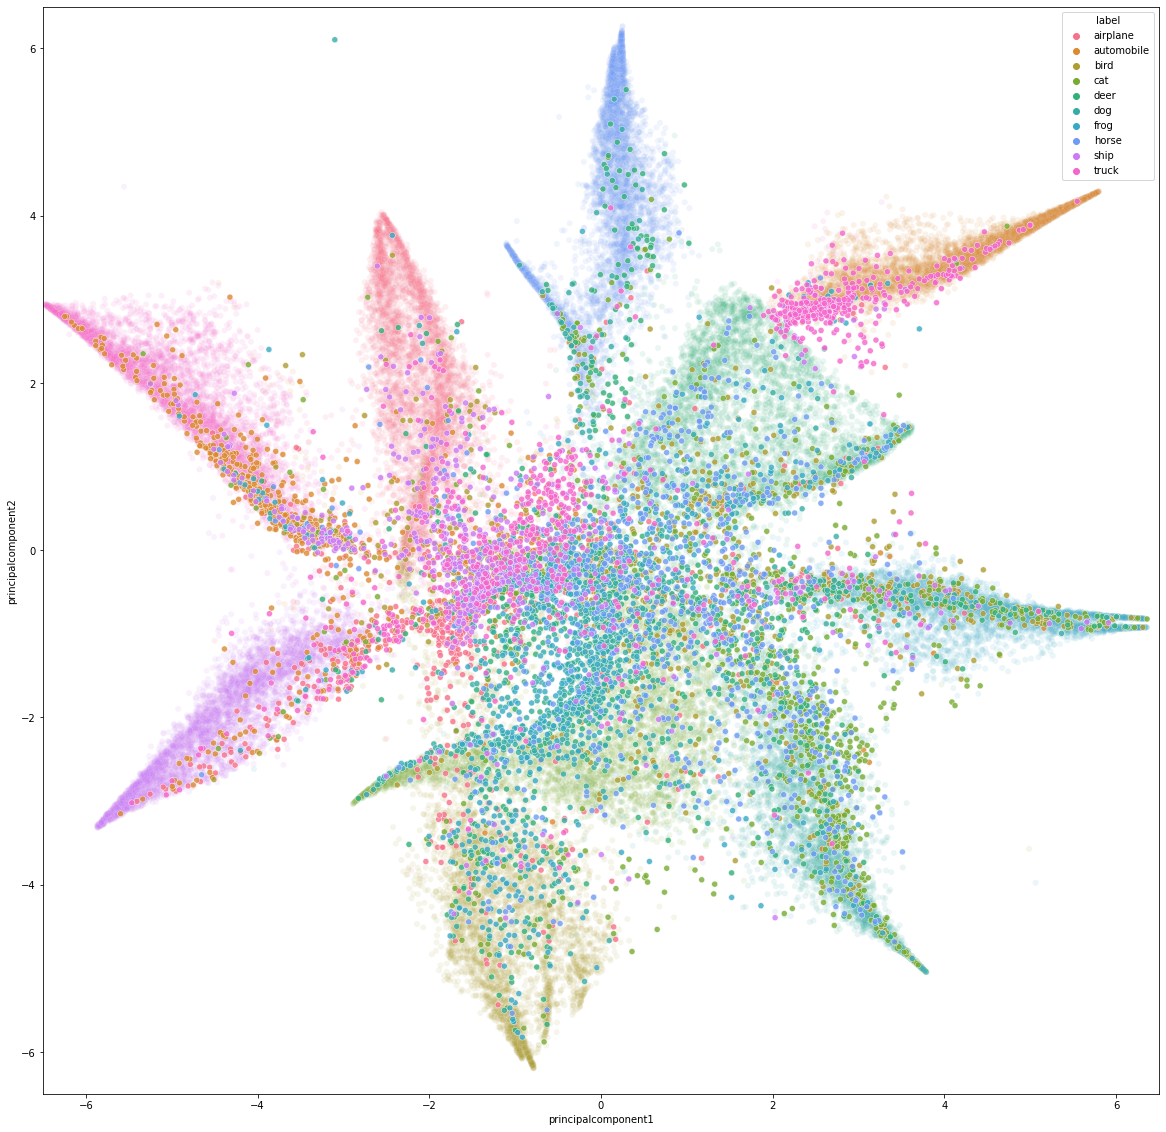

<Figure size 720x720 with 0 Axes>

In [48]:
principalDf = pd.concat([tsne2_subset,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
fig = plt.gcf()
# Change seaborn plot size
fig.set_size_inches(20, 20)
#Original Images
sns.scatterplot(x='principalcomponent1', y='principalcomponent2', data=principalDf[:50000], hue='label', alpha =.1)
#Adversarial Images
sns.scatterplot(x='principalcomponent1', y='principalcomponent2', data=principalDf[50000:], hue='label', alpha = .8, legend=False)
plt.ylim(-6.5,6.5)
plt.xlim(-6.5,6.5)
plt.figure(figsize=(10,10))

# Generate PCA Manifold


In [50]:
from sklearn.decomposition import PCA

In [53]:
#Fit with all data
pca1 = PCA(n_components=2)
pca1_data = pca1.fit_transform(outputs)
df1 = pd.DataFrame(data = pca1_data
             , columns = ['principal component 1', 'principal component 2'])

<Figure size 2160x2160 with 0 Axes>

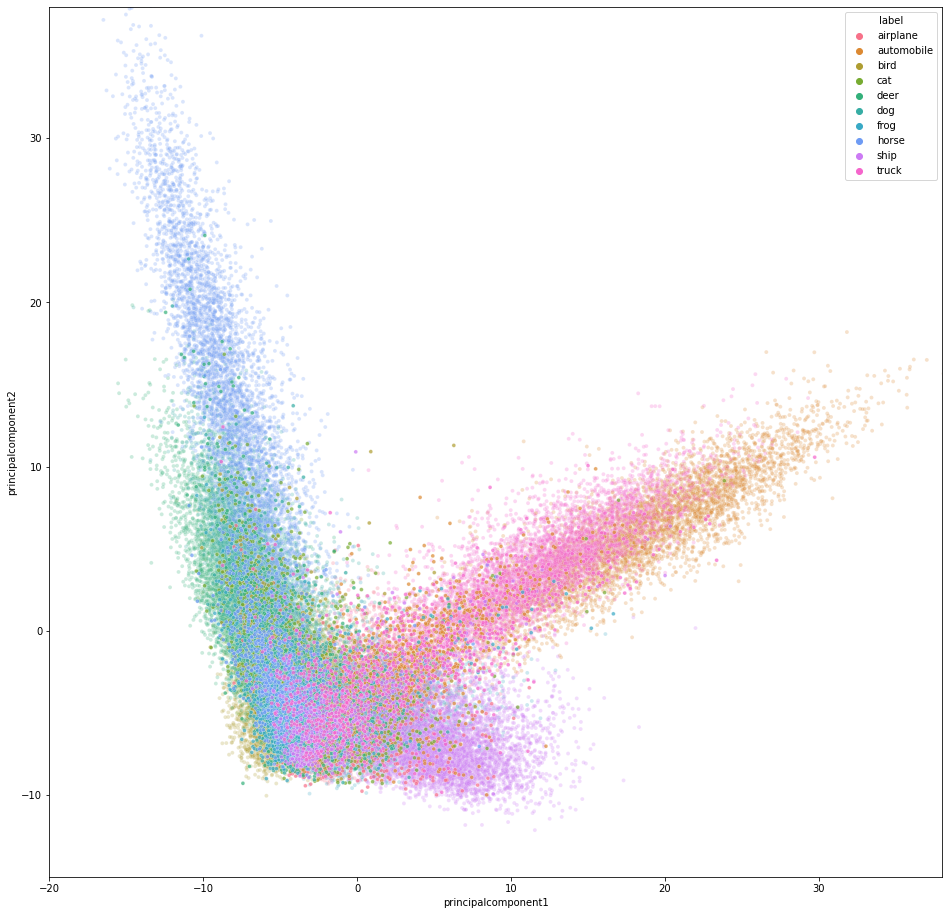

<Figure size 2160x2160 with 0 Axes>

In [65]:
principalDf = pd.concat([df1,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

fig = plt.gcf()
fig.set_size_inches(16,16)

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[:50000], s = 15, alpha = .25, hue='label', legend=True)
sns.scatterplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[50000:], s = 15, alpha = .7, hue='label', legend=False)
plt.ylim(-15,38)
plt.xlim(-20,38)
plt.figure(figsize=(30,30))